In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using devicce: {device}")

Using devicce: cuda


In [ ]:
torch.manual_seed(42)

In [ ]:
import zipfile

import pandas as pd
import zipfile

# Specify the CSV file within the ZIP archive
csv_file_name = 'fashion-mnist_train.csv'  # Replace with the actual file name

# Open the ZIP archive
with zipfile.ZipFile("/content/archive (8).zip", 'r') as zip_ref:
    # Read the CSV file into a DataFrame
    df_train = pd.read_csv(zip_ref.open(csv_file_name))
    df_test = pd.read_csv(zip_ref.open('fashion-mnist_test.csv'))

In [ ]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


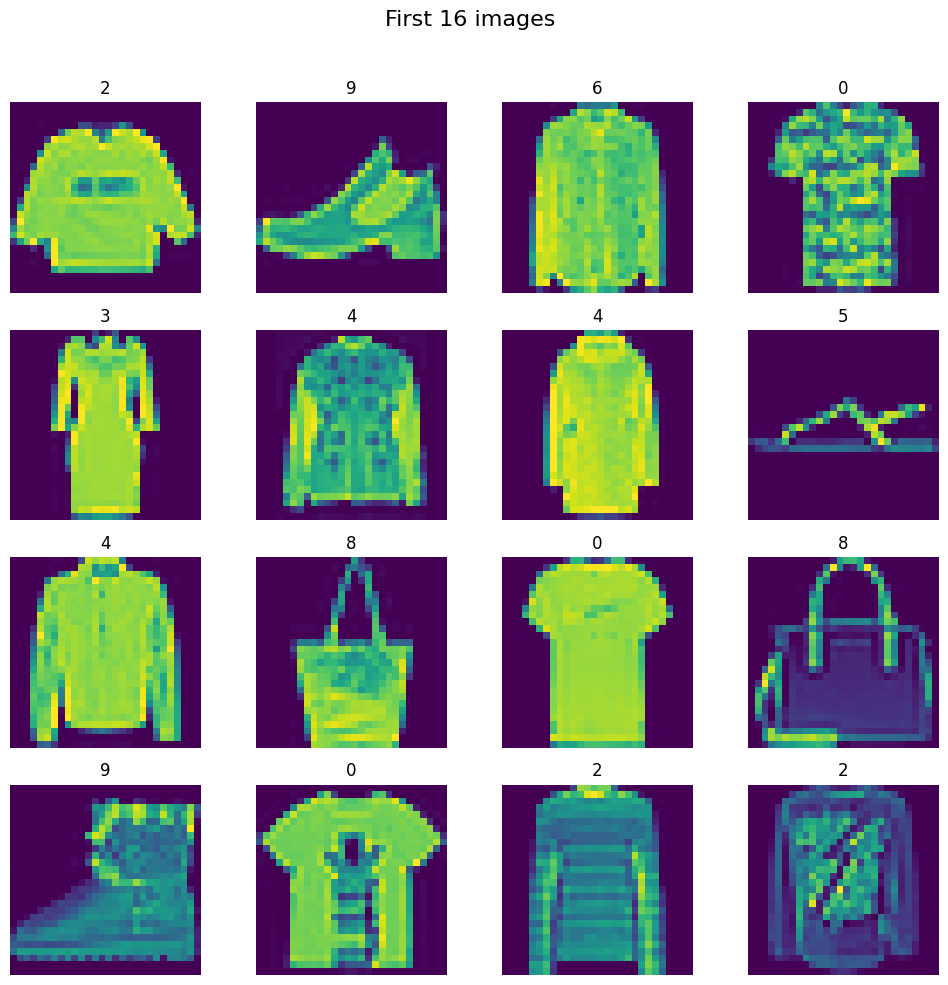

In [ ]:
fig,ax = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images ",fontsize=16)

for i , ax in enumerate(ax.flat):
  img = df_train.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis("off")
  ax.set_title(df_train.iloc[i,0])
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
y_train  = df_train['label'].values
X_train = df_train.drop(columns=['label']).values

In [ ]:
X_test = df_test.drop(columns=['label']).values
y_test  = df_test['label'].values

In [ ]:
# scaling featuress
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
class CustomDataset(Dataset):

  def __init__(self,features,labels):

    self.features = torch.tensor(features,dtype=torch.float32)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index],self.labels[index]

In [ ]:
train_dataset = CustomDataset(X_train,y_train)

In [ ]:
test_dataset = CustomDataset(X_test,y_test)

In [ ]:
class MyNN(nn.Module):

  def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer):
    super().__init__()
    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(0.3))
      input_dim = neurons_per_layer
    layers.append(nn.Linear(neurons_per_layer,output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self,x):
    return self.model(x)

In [ ]:
epochs = 50

In [ ]:
# objective function for hypermater tuning

def objective(trial):

# next hyperemater values frm the saearch web
  num_hidden_layers = trial.suggest_int("num_hidden_layers",1,5)
  neurons_perlayer = trial.suggest_int("neurons_per_layer",8,128,step=8) # Corrected: trial.suggest_int
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
  test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim,output_dim,num_hidden_layers,neurons_perlayer)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()

  # optimizer
  # The optimizer should be assigned to a variable. Previous code did not assign it.
  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    total_epoch_loss = 0
    for batch_features ,batch_labels in train_loader:

      # move data to gpu
      batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs,batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update loss
      optimizer.step()

      total_epoch_loss = total_epoch_loss + loss.item()


  # evaluation
  model.eval()

  total = 0
  correct = 0
  with torch.no_grad():

    for batch_features,batch_labels in test_loader:

      # move data to gpu
      batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

      outputs = model(batch_features)
      _,predicted = torch.max(outputs.data,1)
      total += batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

  accuracy = correct/total # Calculate and assign accuracy
  print(accuracy)

  return accuracy # Return the calculated accuracy

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2025-01-30 12:55:57,996] A new study created in memory with name: no-name-3926d848-7256-4b73-b63e-fbffe0c199c6


### To improve we can increasing n_traials


In [ ]:
study.optimize(objective, n_trials=10)

[I 2025-01-30 12:56:51,857] Trial 0 finished with value: 0.7409 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 112, 'epochs': 10, 'learning_rate': 4.081433548700868e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 1.194840936315404e-05}. Best is trial 0 with value: 0.7409.


0.7409


[I 2025-01-30 13:01:40,893] Trial 1 finished with value: 0.874 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 56, 'epochs': 40, 'learning_rate': 0.08277541606459525, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 0.00021997594206755913}. Best is trial 1 with value: 0.874.


0.874


[I 2025-01-30 13:04:07,603] Trial 2 finished with value: 0.8912 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 72, 'epochs': 30, 'learning_rate': 0.038340092486453405, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 3.173750957161724e-05}. Best is trial 2 with value: 0.8912.


0.8912


[I 2025-01-30 13:09:25,525] Trial 3 finished with value: 0.823 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 56, 'epochs': 50, 'learning_rate': 0.0002125729131619452, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 3.200367275422087e-05}. Best is trial 2 with value: 0.8912.


0.823


[I 2025-01-30 13:11:10,840] Trial 4 finished with value: 0.8687 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 48, 'epochs': 20, 'learning_rate': 3.9874484595762686e-05, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 0.0004925388517358645}. Best is trial 2 with value: 0.8912.


0.8687


In [ ]:
study.best_value


In [ ]:
study.best_params